<a href="https://colab.research.google.com/github/NeerajSahani/Generative-Adversarial-Networks/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype(np.float_)
train_images = (train_images - 127.5) / 127.5

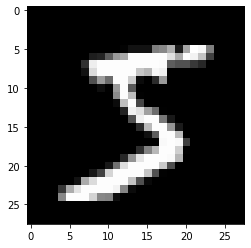

In [6]:
plt.imshow(train_images[0, :, :, 0], cmap='gray')

In [23]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
def get_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), use_bias=True, padding='same')) # -> (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=True, padding='same')) # -> (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), use_bias=True, padding='same', activation='tanh' )) # -> (None, 28, 28, 1)
  return model

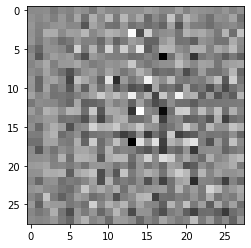

In [15]:
generator = get_generator()
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)
plt.imshow(gen_img[0, :, :, 0], cmap='gray')

In [18]:
def get_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model


In [19]:
discriminator = get_discriminator()
decision = discriminator(gen_img)
print(decision)

tf.Tensor([[0.0035817]], shape=(1, 1), dtype=float32)


In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  total = real_loss + fake_loss
  return total

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)